In [136]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time, datetime as dt
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os
import math, random
from itertools import permutations

import alpha
import alpaca
import database as db
from populate import download_data
from portfolios import Portfolio
from history import *

DataStore = db.DataStore()

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

import random as rand

In [3]:
    
class QLearner(object):                                                                                         
                                                                                        
    def __init__(self, num_states=100, 
                 num_actions = 4, 
                 alpha = 0.2, 
                 gamma = 0.9, 
                 rar = 0.5, 
                 radr = 0.99, 
                 dyna = 0, 
                 verbose = False):
        self.verbose = verbose                                                                                      
        self.num_actions = num_actions                                                                                      
        self.s = 0                                                                                      
        self.a = 0

        self.rar = rar
        self.radr = radr
        self.dyna = dyna
        self.alpha = alpha
        self.gamma = gamma
        self.num_states = num_states
        self.Q = np.zeros((num_states, num_actions))    
        self.T = np.zeros((0, 3), dtype=int)
        self.R = np.zeros((num_states, num_actions))                                                        
                                                                                        
    def querysetstate(self, s):                                                                                         
        """                                                                                         
        @summary: Update the state without updating the Q-table                                                                                         
        @param s: The new state                                                                                         
        @returns: The selected action                                                                                       
        """                                                                                         
        self.s = s

        if rand.uniform(0.0, 1.0) < self.rar:                                                                                     
            action = rand.randint(0, self.num_actions-1) 
        else:
            action = np.argmax(self.Q[self.s, :])

        self.a = action
        return action                                                                                       
                                                                                        
    def query(self,s_prime,r):                                                                                      
        """                                                                                         
        @summary: Update the Q table and return an action                                                                                       
        @param s_prime: The new state                                                                                       
        @param r: The ne state                                                                                      
        @returns: The selected action                                                                                       
        """                      

        # update Q table
        self.Q[self.s, self.a] = (1-self.alpha)*self.Q[self.s, self.a] \
            + self.alpha*(r + self.gamma*self.Q[s_prime, np.argmax(self.Q[s_prime, :])])

        if self.dyna > 0:
            # hallucinate experience
            self.R[self.s, self.a] = (1-self.alpha) * self.R[self.s, self.a] + self.alpha*r
            
            # update T, don't worry about duplicates
            self.T = np.vstack((self.T, np.array((self.s,self.a,s_prime))))

            rando_s = np.random.randint(0, self.num_states-1, size=self.dyna-1)
            rando_a = np.random.randint(0, self.num_actions-1, size=self.dyna-1)

            if self.T.shape[0] > 10:
                for i in range(0, self.dyna-1):
                    # get random number based on number of rows in self.T
                    # this would have same frequency as adding 1 each time find combo
                    row = rand.randint(0, self.T.shape[0]-1)
                    dyna_s = self.T[row,0]
                    dyna_a = self.T[row,1]
                    dyna_s_prime = self.T[row,2]

                    # update Q table...
                    self.Q[dyna_s, dyna_a] = (1-self.alpha)*self.Q[dyna_s, dyna_a] \
                        + self.alpha*(self.R[dyna_s, dyna_a] + self.gamma*self.Q[dyna_s_prime, np.argmax(self.Q[dyna_s_prime, :])])

        # decide to choose randomly or not
        if rand.uniform(0.0, 1.0) < self.rar:                                                                                      
            action = rand.randint(0, self.num_actions-1)    
        else:
            action = np.argmax(self.Q[s_prime, :])
        
        # update rar
        self.rar = self.rar*self.radr

        # set current s and a for use next time
        self.s = s_prime
        self.a = action                                                                                 
        return action
    

In [113]:
def symbol_to_path(symbol, base_dir=None):
    """Return CSV file path given ticker symbol."""
    if base_dir is None:
        base_dir = os.environ.get("MARKET_DATA_DIR", '../data/')
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, addSPY=True, colname = 'Adj Close'):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if addSPY and 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols = ['SPY'] + symbols

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', colname], na_values=['nan'])
        df_temp = df_temp.rename(columns={colname: symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df

def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    import matplotlib.pyplot as plt
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()  
                                                                                        

def graph_ms(ms_portvals, benchmark_portvals, strat_trades):
    #ms_portvals = ms_portvals/ms_portvals.iloc[0]
    benchmark_portvals = benchmark_portvals/benchmark_portvals.iloc[0]
    strat_trades = strat_trades/strat_trades.iloc[0]
    fig = plt.figure()
    plt.style.use('ggplot')
    #plt.plot(ms_portvals, color='red', label='Manual Port vals')
    plt.plot(strat_trades, color='blue', label='QLearner Port vals')
    plt.plot(benchmark_portvals, color='orange', label='Benchmark Port vals')
    plt.xlabel("Date")
    plt.ylabel("Portfolio values")
    plt.legend(loc='upper right')
    fig.suptitle('QLearner vs Manual vs Benchmark')
    fig.savefig("exp1.png")

def graph_strat(strat_trades):
    strat_trades = strat_trades/strat_trades.iloc[0]
    fig = plt.figure()
    plt.style.use('ggplot')
    plt.plot(strat_trades, color='blue', label='QLearner Port vals')
    plt.xlabel("Date")
    plt.ylabel("Portfolio values")
    plt.legend(loc='upper right')
    plt.show()

    

def create_orders(df, symbol):
    orders = df.copy(deep = True)
    orders.columns = ['Shares']
    orders.insert(0, 'Symbol', ''.join(symbol))
    orders.insert(1, 'Order', 0)


    orders.loc[orders['Shares'] > 0, 'Order'] = "BUY"
    orders.loc[orders['Shares'] < 0, 'Order'] = "SELL" 

    # make all positive since Sell/Buy is used
    orders['Shares'] = orders['Shares'].abs().astype(int)

    return orders


def compute_portvals(orders_file, prices = None, start_val = 1000000, commission=9.95, impact=0.005):                                                                                      
    
    if orders_file.shape[0] == 0:
        print('Error: need at least 1 buy or sell')
        return

    df_sorted = orders_file.sort_index()
    start_date = df_sorted.index[0]
    end_date = df_sorted.index[-1]
    symbols = df_sorted.Symbol.unique().tolist()
    dates = pd.date_range(start_date, end_date)
    
    prices = prices.to_frame()
    prices['Cash'] = 1.0

    trades = prices.copy(deep = True)
    trades.loc[:,:] = 0.0
    
    df_impact = trades.copy(deep = True)
    df_impact.drop(df_impact.columns.difference(['Cash']),1,inplace=True)
    commiss = df_impact.copy(deep = True)
    
    df_sorted.index = pd.to_datetime(df_sorted.index)
    for date, row in df_sorted.iterrows():
        if date in trades.index:
            if row['Order'] == 'SELL':
                trades.loc[date] = trades.loc[date]- row['Shares']
                trades.loc[date,'Cash'] = trades.loc[date,'Cash'] + 1 # track commission multiplier
                if impact > 0:
                    df_impact.loc[date] = df_impact.loc[date] - prices.loc[date]*impact*-row['Shares']#trades.loc[date,row['Symbol']]
            else:
                trades.loc[date] = trades.loc[date] + row['Shares']
                trades.loc[date,'Cash'] = trades.loc[date,'Cash'] + 1
                if impact > 0:
                    df_impact.loc[date] = df_impact.loc[date] + prices.loc[date]*impact*row['Shares']

    if commission > 0:
        commiss = (trades['Cash']*commission).to_frame()

    trades['Cash'] = (prices.iloc[:,:-1].mul(trades.iloc[:,:-1]).sum(axis=1)*-1).sub(commiss['Cash'],fill_value=0).sub(df_impact['Cash'],fill_value=0)

    holdings = trades.copy(deep = True)
    
    # each row is sum of all previous rows (excluding Cash)
    holdings.iloc[:,:-1] = holdings.rolling(len(holdings), min_periods=1).sum()
    holdings['Cash'][0] = holdings['Cash'][0] + start_val
    holdings.iloc[:,-1] = holdings.iloc[:,-1].rolling(len(holdings), min_periods=1).sum()

    values = holdings.copy(deep = True)
    values.loc[:,:] = 0
    values = prices*holdings

    portvals = values.copy(deep = True)
    portvals = values.sum(axis=1)
    portvals = portvals.to_frame()
    return portvals



class StateLearner:
    
    def __init__(self,
                 symbol = "IBM",
                 sd=dt.datetime(2008,1,1),
                 ed=dt.datetime(2009,1,1),
                 indicators=['SMA', 'MFI', 'BBANDS'],
                 money = 10000, 
                 num_bins=10,
                 verbose = False,
                 impact=0.005):
        
        self.symbol = symbol
        self.sd = sd
        self.ed = ed
        self.inidicators = indicators
        self.money = money
        self.num_bins = num_bins
        self.verbose = verbose
        self.impact = impact
        self.state_translate = {}
        
        self.num_inds = len(indicators)

        history = History(DataStore, symbol, [sd, ed], indicators=indicators)
        data = history.indicators
        
        self.prices = data.iloc[:, -1].astype(float)
        self.indicators = data.iloc[:, :-1].astype(float)
        
        self.discretize(self.indicators, self.num_bins)
        self.counter = int(''.join([str(9) for x in range(self.num_inds)]))
        
        max_val = int(''.join(np.full(len(np.arange(self.num_inds)), 9).astype(str).tolist()))
        state = ''.join([str(self.num_bins) + '_' for _ in range(self.num_inds)])[:-1]
        max_state = self.translate_state(max_val, state)

        self.learner = QLearner(
            num_states = max_state*self.num_bins**self.num_inds,
            num_actions = 3,
            alpha = 0.2,
            gamma = 0.9,
            rar = 0.98,
            radr = 0.999,
            dyna = 0,
            verbose = self.verbose)

        
    def discretize(self, df_indicators, num_bins=10):
        self.bins = []
        for indicator in range(df_indicators.shape[1]):
            self.bins.append(pd.qcut(df_indicators.iloc[:,indicator], num_bins, labels=(np.arange(num_bins)+1).tolist(), retbins=True))
        
        
    def translate_state(self, max_val: int, state: str):
        """given some logical max value, the bin number, and a state separated by '_',
        translate state values where some bin is 10 or higher,
        i.e. 0_1_10 is not 110 but some number > 999 (for 3 indicators, bin size 10)"""
        if state in self.state_translate:
            return self.state_translate[state]
        self.counter += 1
        self.state_translate[state] = self.counter
        return self.counter

    
    def parse_state(self, day):
        """Get state on a day; if any value > 9, call alternate method tranlsate_state"""
        s = ''
        is_gt_ten = False
        for bin in self.bins:
            x = pd.DataFrame(bin[0])
            bin_num = x.loc[day][0]
            if int(bin_num) > 9:
                is_gt_ten = True
            s += str(bin_num) + '_'
        s = s[:-1]
        max_num = int(''.join([str(9) for x in range(self.num_inds)]))
        if is_gt_ten:
            return self.translate_state(max_num, s)
        s = int(s.replace('_', ''))
        return s

    

    def learn(self):

        converged = False
        start_time = time.time()
        buffet_max = 25
        trades = pd.DataFrame(0, index = self.prices.index, columns = [self.prices.name])
        trades_dupl = trades.copy(deep = True)

        while not converged and time.time()-start_time < buffet_max:

            days = iter(self.indicators.index.values)
            day = next(days)
            
            enter = True
            long_t = False
            short_t = False
            action = -999
            previous_price = 0
            
            state = self.parse_state(day)
            self.learner.querysetstate(state) # leave action -999 first go around

            while True:
                #Calculate reward here... first day = 0
                # 0 is long, 1 is short, 2 is hold
                #impact_effect = prices.loc[day][0]*self.impact
                impact_effect = previous_price*self.impact
                if action == -999:
                    reward = 0
                elif action == 0 and self.prices.loc[day]-impact_effect > previous_price:
                    reward = 1
                elif action == 0 and self.prices.loc[day]-impact_effect < previous_price:
                    reward = -1
                elif action == 1 and self.prices.loc[day]+impact_effect < previous_price:
                    reward = 1
                elif action == 1 and self.prices.loc[day]+impact_effect > previous_price:
                    reward = -1
                else:
                    reward = 0

                previous_price = self.prices.loc[day]
                action = self.learner.query(state, reward)
                
                # with action mark long, short, hold
                # if action == long (0), buy 1000/2000
                # if short (1), sell 1000/2000
                # if hold (2), do nothing
                if action == 0:
                    # go long
                    if enter:
                        trades.loc[day] = 1000
                        enter = False
                    elif not long_t:
                            trades.loc[day] = 2000
                    long_t = True
                    short_t = False
                elif action == 1:
                    #go short
                    if enter:
                        trades.loc[day] = -1000
                        enter = False
                    elif not short_t:
                            trades.loc[day] = -2000
                    long_t = False
                    short_t = True

                try:
                    day = next(days)
                    state = self.parse_state(day)
                except StopIteration:
                    break

            if trades.equals(trades_dupl):
                converged = True
            else:
                trades_dupl = trades.copy(deep = True)
                trades.iloc[:,:] = 0
        print(f'Converged: {converged}')

    # this method should use the existing policy and test it against new data
    def testPolicy(self,
        symbol = "IBM",
        sd=dt.datetime(2009,1,1),
        ed=dt.datetime(2009,1,1),
        indicators=['SMA', 'MFI', 'BBANDS'],
        money = 10000, 
        num_bins=10):

        self.learner.rar = 0
        
        history = History(DataStore, symbol, [sd, ed], indicators=indicators)
        data = history.indicators
        
        prices = data.iloc[:, -1].astype(float)
        indicators = data.iloc[:, :-1].astype(float)
                                                                                      
        enter = True
        long_t = False
        short_t = False
        
        trades = pd.DataFrame(0, index = prices.index, columns = [prices.name])
        
        self.discretize(indicators, num_bins)
        
        days = iter(indicators.index.values)
        day = next(days)

        while True:
            state = self.parse_state(day)
            action = self.learner.querysetstate(state)
            if action == 0:
                # go long
                if enter:
                    trades.loc[day] = 1000
                    enter = False
                elif not long_t:
                    trades.loc[day] = 2000
                long_t = True
                short_t = False
            elif action == 1:
                #go short
                if enter:
                    trades.loc[day] = -1000
                    enter = False
                elif not short_t:
                    trades.loc[day] = -2000
                long_t = False
                short_t = True

            try:
                day = next(days)
            except StopIteration:
                break

        return trades

Converged: True


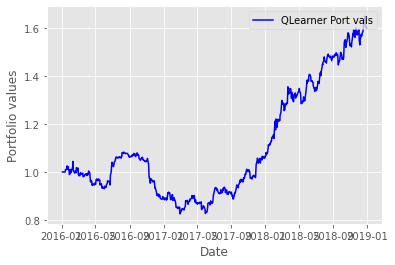

In [130]:
symbol = 'JPM'
sd = dt.datetime(2016,1,1)
ed=dt.datetime(2018,12,31)
indicators = ['SMA','OBV', 'MFI', 'BBANDS', 'SAR', 'T3', 'MOM', 'MIDPRICE', 'WMA']
indicators = ['SAR', 'T3', 'MIDPRICE', 'WMA']
sv = 100000
num_bins = 10
verbose = False
impact = 0.005

seed = 4
np.random.seed(seed)
random.seed(seed)

sl = StateLearner(symbol, sd, ed, indicators, sv, num_bins, verbose, impact)

sl.learn()

strat_trades = sl.testPolicy(symbol, sd, ed, indicators, sv, num_bins)
strat_trades_create = create_orders(strat_trades, symbol)

history = History(DataStore, symbol, [sd, ed], indicators=indicators)
data = history.indicators
prices = data.iloc[:, -1].astype(float)
#indicators = data.iloc[:, :-1].astype(float)

strat_portvals = compute_portvals(strat_trades_create, prices=prices, start_val=sv, commission=0, impact=impact)

graph_strat(strat_portvals)

In [134]:
strat_portvals.iloc[-1][0]

159943.03741270004

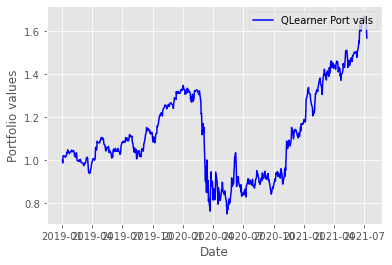

In [126]:
#out of sample
sd = dt.datetime(2019,1,1)
ed=dt.datetime(2021,12,31)

strat_trades = sl.testPolicy(symbol, sd, ed, indicators, sv, num_bins)
strat_trades_create = create_orders(strat_trades, symbol) # correct BUY/SELL format

history = History(DataStore, symbol, [sd, ed], indicators=indicators)
data = history.indicators
prices = data.iloc[:, -1].astype(float)
#indicators = data.iloc[:, :-1].astype(float)

strat_portvals = compute_portvals(strat_trades_create, prices=prices, start_val=sv, commission=0, impact=impact)

graph_strat(strat_portvals)

In [ ]:
def find_best_four_indicators(indicators):
    symbol = 'JPM'
    sd = dt.datetime(2016,1,1)
    ed=dt.datetime(2018,12,31)
    
    sv = 100000
    num_bins = 10
    verbose = False
    impact = 0.005

    seed = 4
    np.random.seed(seed)
    random.seed(seed)

    sl = StateLearner(symbol, sd, ed, indicators, sv, num_bins, verbose, impact)

    sl.learn()

    strat_trades = sl.testPolicy(symbol, sd, ed, indicators, sv, num_bins)
    strat_trades_create = create_orders(strat_trades, symbol)

    history = History(DataStore, symbol, [sd, ed], indicators=indicators)
    data = history.indicators
    prices = data.iloc[:, -1].astype(float)
    #indicators = data.iloc[:, :-1].astype(float)

    strat_portvals_in_sample = compute_portvals(strat_trades_create, prices=prices, start_val=sv, commission=0, impact=impact)
    
    sd = dt.datetime(2019,1,1)
    ed=dt.datetime(2021,12,31)

    strat_trades = sl.testPolicy(symbol, sd, ed, indicators, sv, num_bins)
    strat_trades_create = create_orders(strat_trades, symbol) # correct BUY/SELL format

    history = History(DataStore, symbol, [sd, ed], indicators=indicators)
    data = history.indicators
    prices = data.iloc[:, -1].astype(float)
    #indicators = data.iloc[:, :-1].astype(float)

    strat_portvals_out_sample = compute_portvals(strat_trades_create, prices=prices, start_val=sv, commission=0, impact=impact)
    
    return int(strat_portvals_in_sample.iloc[-1][0]), int(strat_portvals_out_sample.iloc[-1][0])
    
indicators = ['SMA','OBV', 'MFI', 'BBANDS', 'SAR', 'T3', 'MOM', 'MIDPRICE', 'WMA']
max_in_sample = (0, [])
max_out_sample = (0, [])
counter = 0
for perm in list(permutations(indicators, 4)):
    insample, outsample = find_best_four_indicators(list(perm))
    if insample > max_in_sample[0]:
        max_in_sample = (insample, list(perm))
    if outsample > max_out_sample[0]:
        max_out_sample = (outsample, list(perm))
    print(counter)
    counter += 1
        
print(max_in_sample)
print(max_out_sample)

Converged: True
0
Converged: True
1
Converged: True
2
